# Simple embedding using TF-IDF

1. Create TF-IDF for each terms
2. Using the mapping for `poinf-> publications` created, create `concat_toks` for each indivudal

In [22]:
import pandas as pd
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
import os
DATA_DIR = '../../data/data_schoolofinf/'

## import corpus:

In [3]:
lookup_combined_toks = pd.read_pickle(os.path.join(DATA_DIR,'toks','toks.combined.pkl'))

In [4]:
lookup_combined_toks.head(3)

,year,toks_metada,toks_pdf2txt
pub_id,,,
400818dc-63af-4a26-80c5-906f98e1f8ab,1989,"[ballooning, stability, analysis, jet, hmode, ...",
18b1a861-afef-4fff-bc80-d02e05be18c4,2013,"[query, processing, data, integration, chapter...",
309fdbfc-227b-4588-9264-f0f4e3cadfcb,1994,"[comprehension, syntax, syntax, comprehension,...","[comprehension, syntax, citation, published, v..."


In [7]:
corpus_metadata = lookup_combined_toks.toks_metada.tolist()

In [8]:
len(corpus_metadata)

8867

In [10]:
dictionary_metada = Dictionary.load(os.path.join(DATA_DIR, 'corpora', 'dictionary.meta'))

In [42]:
tfidf_metada = TfidfModel(dictionary=dictionary_metada, normalize=True)
# tfidf_metada.save(os.path.join(DATA_DIR,'models','tfidf_metadata'))

In [40]:
test = corpus_metadata[0]
print(test)

['ballooning', 'stability', 'analysis', 'jet', 'hmode', 'discharge', 'previous', 'study', 'stability', 'large', 'aspect', 'ratio', 'model', 'equilibrium', 'ideal', 'mhd', 'ballooning', 'mode', 'shown', 'across', 'bulk', 'plasma', 'exist', 'two', 'marginally', 'stable', 'value', 'pressure', 'gradient', 'parameter', 'define', 'unstable', 'zone', 'separate', 'first', 'small', 'stable', 'region', 'second', 'large', 'stable', 'region', 'close', 'separatrix', 'however', 'first', 'second', 'region', 'coalesce', 'surface', 'averaged', 'current', 'density', 'exceeds', 'critical', 'value', 'plasma', 'region', 'stable', 'ballooning', 'mode', 'value', 'pressure', 'gradient', 'paper', 'extend', 'result', 'jet', 'mode', 'equilibrium', 'using', 'finite', 'aspect', 'ratio', 'ballooning', 'formalism', 'ass', 'relevance', 'ideal', 'ballooning', 'stability', 'discharge', 'particular', 'analyse', 'shot', 'time', 'sec', 'phase', 'proceeding', '16th', 'european', 'conference', 'controlled', 'fusion', 'plasm

In [24]:
import gensim.similarities as sim

In [43]:
corpus_bows = [dictionary_metada.doc2bow(doc) for doc in corpus_metadata]

## Create mapping for individuals

In [105]:
df_pubmapping = pd.read_pickle(os.path.join(DATA_DIR, 'poinf_to_pub_mapping.pkl'))

In [106]:
df_pubmapping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 2 columns):
id         288 non-null object
pub_ids    288 non-null object
dtypes: object(2)
memory usage: 4.6+ KB


In [116]:
# We are only interested in individuals in the collab graph:
poinf_ids = pd.read_csv(os.path.join(DATA_DIR,'poinf_collabgraph_1997-017.txt'),sep='\n',names=['id'])

In [117]:
poinf_ids.head(3)

,id
0,dbb07214-3753-4bba-a630-e1857e7efb09
1,2b36a690-b726-438e-8eb7-1128a7e7775d
2,666503f8-4508-4fd8-8645-18e0436423cf


In [127]:
# merge the two dataframes, so that those that we are not interested are excluded:
df_pubmapping.set_index('id', inplace=True)
poinf_ids.set_index('id', inplace=True) 
df_pubmapping_4_collabgraph = poinf_ids.join(df_pubmapping,how='left')

In [130]:
len(df_pubmapping_4_collabgraph)

194

In [131]:
def gen_toks(pub_ids, with_pdf=False):
    """
    Take in a set of pub_ids and concatenate all the tokens together
    Args:
        width_pdf (bool) : define if we should use the tokens generated from pdf too
    """
    _df = lookup_combined_toks.loc[list(pub_ids)]
    
    # Constraint to 1997-2017
    _df.drop(_df[(_df.year>2017)|(_df.year<1997)].index,inplace=True)
    out = []
    if with_pdf:
        for a,b in zip(_df.toks_metada.tolist(), _df.toks_pdf2txt.tolist()):
            out += a + b
            
    else:
        for a in _df.toks_metada.tolist():
            out += a
    return out

In [134]:
df_pubmapping_4_collabgraph['toks'] = df_pubmapping_4_collabgraph['pub_ids'].apply(gen_toks)

In [135]:
df_pubmapping_4_collabgraph.head(3)

,pub_ids,toks
id,,
dbb07214-3753-4bba-a630-e1857e7efb09,"{b5b18302-7175-4345-b06b-4ae88e57f502, 9bdcc5f...","[clustering, motion, data, onbody, wireless, s..."
2b36a690-b726-438e-8eb7-1128a7e7775d,"{346d4fc2-53b5-4bd0-b0d9-ed91dafe2d26, 37563ee...","[lifelong, transfer, learning, option, hierarc..."
666503f8-4508-4fd8-8645-18e0436423cf,"{7cf97392-f328-4c7b-b136-72c61ecfc8b5, 6b50136...","[incremental, bayesian, learning, semantic, ca..."


## Generate tfidf scores for each document:

In [136]:
df_pubmapping_4_collabgraph[
    'tfidf'] = df_pubmapping_4_collabgraph['toks'].apply(
        lambda x: tfidf_metada[dictionary_metada.doc2bow(x)] if len(x) else None
    )

In [138]:
df_pubmapping_4_collabgraph.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194 entries, dbb07214-3753-4bba-a630-e1857e7efb09 to 5f66e548-1906-404b-a625-40a1bbbdce1e
Data columns (total 3 columns):
pub_ids    194 non-null object
toks       194 non-null object
tfidf      194 non-null object
dtypes: object(3)
memory usage: 11.1+ KB


## Create Matrix to lookup similarity

In [158]:
index = sim.Similarity(
    output_prefix='20yrs_metadata',
    corpus=df_pubmapping_4_collabgraph.tfidf.tolist(),
    num_features=len(dictionary_metada))

In [143]:
index.save(os.path.join(DATA_DIR, 'models','index_20yrs_metadata'))

In [161]:
heatmap = []
for i in range(len(df_pubmapping_4_collabgraph)):
    heatmap.append(index[df_pubmapping_4_collabgraph.tfidf.iloc[i]])

In [166]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [164]:
heatmap = np.array(heatmap)

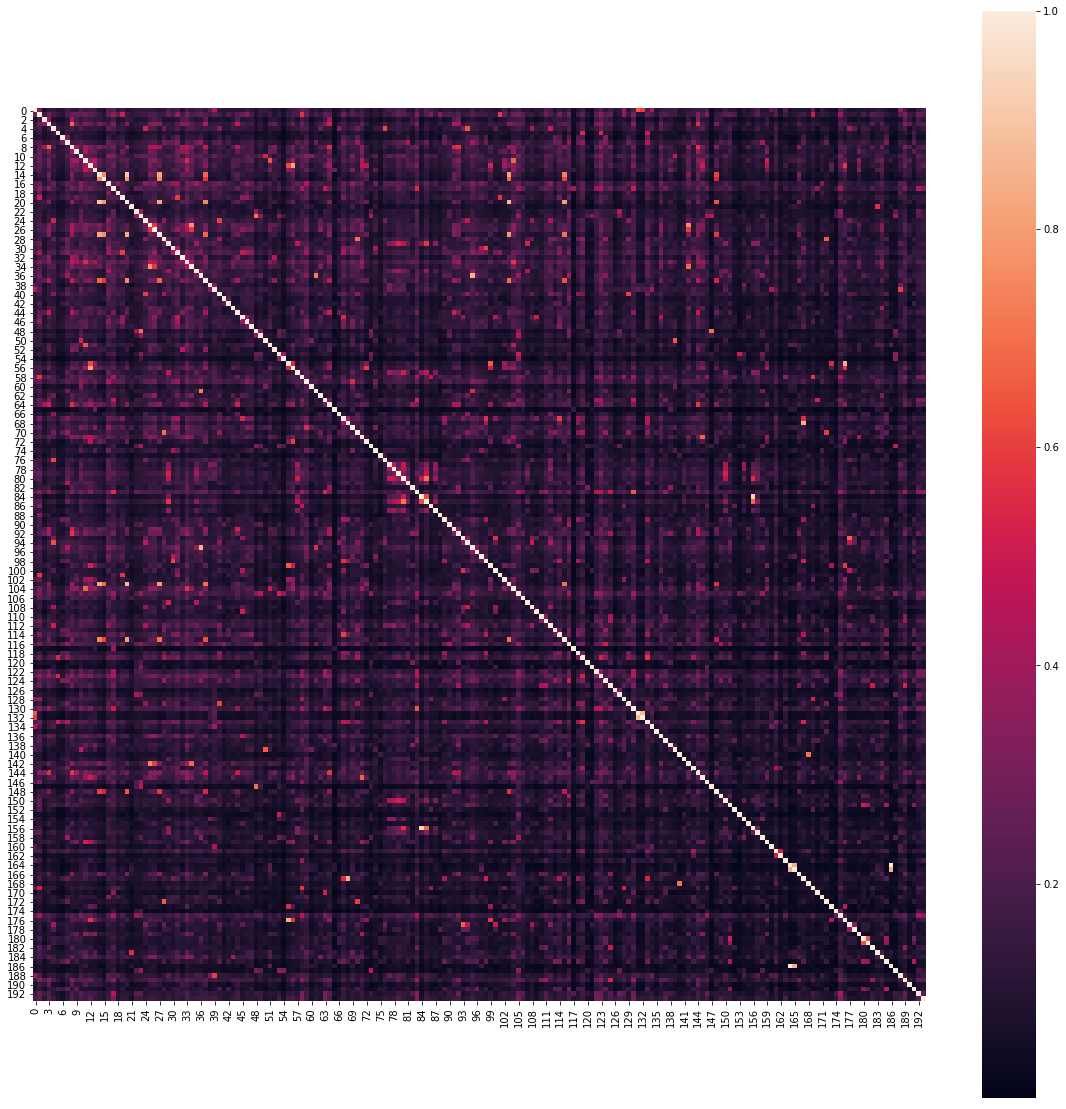

In [170]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
sns.heatmap(heatmap,ax=ax,square=True)